In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

import astropy.coordinates as coord
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.coordinates import match_coordinates_sky

from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch

Vizier.ROW_LIMIT = 9999999

# PLOT STYLE
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind') # Color blind friendly palette

Could not import regions, which is required for some of the functionalities of this module.


In [26]:
# Load the HWO catalog data from CSV (consider using absolute path or config for portability)
df_HWO = pd.read_csv('HPICv1.0/full_HPIC.txt', sep='|')
df_HWO = df_HWO.reset_index(drop=True)
df_HWO.sort_values('ra')


df_catalogs_info = pd.read_csv('act.catalogs.info.csv',comment='#').reset_index(drop=True)

with open('act.catalogs.cols.json', 'r') as f:
    cols = json.load(f)

# Convert dictionary to a pandas DataFrame
# The key will be the column name, and the list will become the rows under that column
df_cols = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cols.items()]))
display(df_cols)

rad_search = 1.0

for catalog,vizier_code in zip(df_catalogs_info['catalog'],df_catalogs_info['vizier_code']):

    print(f"CROSSMATCH: Catalog and Vizier code - {catalog} {vizier_code} ::::::::::::::::::::::::::")
    # Load the Vizier catalog (Astropy Table)
    astab_viziercat = Vizier.get_catalogs(vizier_code)
    # Extract the desired catalog
    astab_catalog = astab_viziercat[0] 
    # Print column names of the Vizier catalog (for reference)
    #print("CROSSMATCH: Columns in Vizier Catalog:", astab_catalog.colnames)
    try:
        astab_catalog = astab_catalog[~astab_catalog['RAJ2000'].mask]
        #astab_catalog['RAJ2000'] = astab_catalog['RAJ2000']  * u.hourangle
        #print(astab_catalog['RAJ2000'])
        astab_catalog = astab_catalog[~astab_catalog['DEJ2000'].mask]
        #astab_catalog['DEJ2000'] = astab_catalog['DEJ2000']  * u.deg

        # HWO List SkyCoord object
        c1 = SkyCoord(df_HWO['ra']*u.deg, df_HWO['dec']*u.deg, frame='icrs')
        # Vizier catalog SkyCoord object
        c2 = SkyCoord(astab_catalog['RAJ2000'], astab_catalog['DEJ2000'], frame='icrs',unit=(u.hourangle, u.deg))

    except:
        astab_catalog = astab_catalog[~astab_catalog['_RA'].mask]
        astab_catalog = astab_catalog[~astab_catalog['_DE'].mask]
        # HWO List SkyCoord object
        c1 = SkyCoord(df_HWO['ra']*u.deg, df_HWO['dec']*u.deg, frame='icrs')
        # Vizier catalog SkyCoord object
        c2 = SkyCoord(astab_catalog['_RA'], astab_catalog['_DE'], frame='icrs')

       
    # Defining condition of radius of search
    max_sep = rad_search * u.arcsec
    # Crossmatch between HWO List (c1) and Vizier catalog (c2)
    idx, d2d, d3d = c1.match_to_catalog_sky(c2)
    idx_, d2d_, d3d_ = c2.match_to_catalog_sky(c1)
    print((idx))

    #Separation constrain condition
    sep_constraint = d2d < max_sep
    sep_constraint_ = d2d_ < max_sep
    # Coordinate matches from the HWO list and Vizier catalog
    c_matches = c1[sep_constraint]
    c_matches_2 = c2[sep_constraint_]
    #print('c_matches',(c_matches))
    print('c_matches',len(c_matches_2))

    # Matches from HWO list in the given Vizier catalog
    #df_HWO_matches = df_HWO[idx[sep_constraint]]
    astab_catalog_matches = astab_catalog[idx[sep_constraint]]
    astab_catalog_matches = astab_catalog_matches.iloc[idx]


    display("Matched entries from Vizier catalog:\n",astab_catalog_matches)
    #display("Matched entries from DF_HWO:\n",df_HWO_matches)

    # HWO list's data of matched stars from the Vizier Catalog
    astab_my_matches = df_HWO[sep_constraint]
    #display("Matched stars from HWO catalog:\n",astab_my_matches)
    
    columns_serie = df_cols[catalog]
    columns = columns_serie.dropna().tolist()
    #print(type(columns))
    #print(columns)
    #"""
    print("CROSSMATCH: Creating CSV file")
    table1 = df_HWO
    table2 = astab_catalog_matches[columns].to_pandas()
    try: 
        table1.sort_values('ra')
        table2.sort_by('RAJ2000')
    except:
        table1.sort_values('ra')
        table2.sort_values('_RA')
        #table1 = Table.from_pandas(df_HWO)
    #table2 = astab_catalog_matches[columns]#.to_pandas()
    #from astropy.table import vstack
    display(table1)
    display(table2)

    #print(vstack([table1, table2], join_type='inner'))
    merged_df = pd.merge(table1, table2, left_index=True, right_index=True)
    #display(merged_df)
    merged_df.to_csv('20241216.HWO.'+catalog+'.merge.csv',index=False)

    #"""
    print("CROSSMATCH: Done")
    
    sys.exit()

,Boro18,Henry96,White07,Adibekyan12,Rice2020,Holmberg2007,Brewer2016,Cincunegui2007
0,Name,HD,HD,Star,Name,Name,Name,Name
1,SimbadName,S_CTIO_,Simbad,Teff,Teff,RAJ2000,Teff,__S_
2,_RA,S_MW_,RAJ2000,logg,logg,DEJ2000,logg,__FHK_
3,_DE,logR__HK_,DEJ2000,Vtur,vsini,logTe,S,__FHa_
4,Smean,_RA,EWHa,SimbadName,SimbadName,vsini,logRhk,Simbad
5,Smed,_DE,u_vsini,_RA,_RA,Simbad,Vbr,_RA
6,logRpHK,NaN,vsini,_DE,_DE,NaN,Vsini,_DE
7,NaN,NaN,S,NaN,NaN,NaN,Vmac,NaN
8,NaN,NaN,u_S,NaN,NaN,NaN,Vrad,NaN
9,NaN,NaN,RHK,NaN,NaN,NaN,SNR,NaN


CROSSMATCH: Catalog and Vizier code - Henry96 J/AJ/111/439 ::::::::::::::::::::::::::
[568 185 464 ... 862 849 849]
c_matches 629


ValueError: Cannot create TableLoc object with no indices

In [ ]:
# Load the HWO catalog data from CSV (consider using absolute path or config for portability)
df_HWO = pd.read_csv('HPICv1.0/full_HPIC.txt', sep='|')
df_HWO = df_HWO.reset_index(drop=True)
df_HWO.sort_values('ra')


df_catalogs_info = pd.read_csv('act.catalogs.info.csv',comment='#').reset_index(drop=True)

with open('act.catalogs.cols.json', 'r') as f:
    cols = json.load(f)

# Convert dictionary to a pandas DataFrame
# The key will be the column name, and the list will become the rows under that column
df_cols = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cols.items()]))
display(df_cols)

rad_search = 2.0

for catalog,vizier_code in zip(df_catalogs_info['catalog'],df_catalogs_info['vizier_code']):

    print(f"CROSSMATCH: Catalog and Vizier code - {catalog} {vizier_code} ::::::::::::::::::::::::::")
    # Load the Vizier catalog (Astropy Table)
    astab_viziercat = Vizier.get_catalogs(vizier_code)
    # Extract the desired catalog
    astab_catalog = astab_viziercat[0] 
    # Print column names of the Vizier catalog (for reference)
    #print("CROSSMATCH: Columns in Vizier Catalog:", astab_catalog.colnames)
    try:
        astab_catalog = astab_catalog[~astab_catalog['RAJ2000'].mask]
        #astab_catalog['RAJ2000'] = astab_catalog['RAJ2000']  * u.hourangle
        #print(astab_catalog['RAJ2000'])
        astab_catalog = astab_catalog[~astab_catalog['DEJ2000'].mask]
        #astab_catalog['DEJ2000'] = astab_catalog['DEJ2000']  * u.deg

        # HWO List SkyCoord object
        c1 = SkyCoord(df_HWO['ra']*u.deg, df_HWO['dec']*u.deg, frame='icrs')
        # Vizier catalog SkyCoord object
        c2 = SkyCoord(astab_catalog['RAJ2000'], astab_catalog['DEJ2000'], frame='icrs',unit=(u.hourangle, u.deg))

    except:
        astab_catalog = astab_catalog[~astab_catalog['_RA'].mask]
        astab_catalog = astab_catalog[~astab_catalog['_DE'].mask]
        # HWO List SkyCoord object
        c1 = SkyCoord(df_HWO['ra']*u.deg, df_HWO['dec']*u.deg, frame='icrs')
        # Vizier catalog SkyCoord object
        c2 = SkyCoord(astab_catalog['_RA'], astab_catalog['_DE'], frame='icrs')

       
    # Defining condition of radius of search
    max_sep = rad_search * u.arcsec
    # Crossmatch between HWO List (c1) and Vizier catalog (c2)
    #idx, d2d, d3d = c1.search_around_sky(c2)
    #astropy.coordinates.search_around_sky(coords1, coords2, seplimit, storekdtree='kdtree_sky'
    idx , idx2, sep2d, dist3d = c1.search_around_sky(c2, max_sep)
    #idx_, d2d_, d3d_ = c2.match_to_catalog_sky(c1)
    print(len(idx),len(idx2))

    #Separation constrain condition
    #sep_constraint = d2d < max_sep
    #sep_constraint_ = d2d_ < max_sep
    # Coordinate matches from the HWO list and Vizier catalog
    #c_matches = c1[sep_constraint]
    #c_matches_2 = c2[sep_constraint_]
   # print('c_matches',len(c_matches))
    #print('c_matches',len(c_matches_2))

    # Matches from HWO list in the given Vizier catalog
    #print('####')
    #print(idx, sep_constraint)
    #print('####')

    #astab_catalog_matches = astab_catalog[idx[sep_constraint]]
    astab_catalog_matches = astab_catalog[idx]
    df_HWO_matches = df_HWO.iloc[idx2]

    display("Matched entries from Vizier catalog:\n",astab_catalog_matches)
    display("Matched entries from DF_HWO:\n",df_HWO_matches)

    # HWO list's data of matched stars from the Vizier Catalog
    #astab_my_matches = df_HWO[sep_constraint]
    #display("Matched stars from HWO catalog:\n",astab_my_matches)
    
    columns_serie = df_cols[catalog]
    columns = columns_serie.dropna().tolist()
    #print(type(columns))
    #print(columns)
    #"""
    print("CROSSMATCH: Creating CSV file")
    table1 = df_HWO_matches.reset_index()
    table2 = astab_catalog_matches[columns].to_pandas().reset_index()
    """
    try: 
        table1.sort_values('ra')
        table2.sort_by('RAJ2000')
    except:
        table1.sort_values('ra')
        table2.sort_values('_RA')
        #table1 = Table.from_pandas(df_HWO)
    """
    #table2 = astab_catalog_matches[columns]#.to_pandas()
    #from astropy.table import vstack
    #display(table1)
    #display(table2)

    #print(vstack([table1, table2], join_type='inner'))
    #merged_df = pd.merge(table1, table2, left_index=True, right_index=True)
    merged_df = pd.concat([table1, table2], axis=1).drop_duplicates(subset=columns)
    #display(merged_df)
    merged_df.to_csv('20241216.HWO.'+catalog+'.merge.csv',index=False)

    #"""
    print("CROSSMATCH: Done")
    display(merged_df)
    
    sys.exit()

,Boro18,Henry96,White07,Adibekyan12,Rice2020,Holmberg2007,Brewer2016,Cincunegui2007
0,Name,HD,HD,Star,Name,Name,Name,Name
1,SimbadName,S_CTIO_,Simbad,Teff,Teff,RAJ2000,Teff,__S_
2,_RA,S_MW_,RAJ2000,logg,logg,DEJ2000,logg,__FHK_
3,_DE,logR__HK_,DEJ2000,Vtur,vsini,logTe,S,__FHa_
4,Smean,_RA,EWHa,SimbadName,SimbadName,vsini,logRhk,Simbad
5,Smed,_DE,u_vsini,_RA,_RA,Simbad,Vbr,_RA
6,logRpHK,NaN,vsini,_DE,_DE,NaN,Vsini,_DE
7,NaN,NaN,S,NaN,NaN,NaN,Vmac,NaN
8,NaN,NaN,u_S,NaN,NaN,NaN,Vrad,NaN
9,NaN,NaN,RHK,NaN,NaN,NaN,SNR,NaN


CROSSMATCH: Catalog and Vizier code - Henry96 J/AJ/111/439 ::::::::::::::::::::::::::
657 657


'Matched entries from Vizier catalog:\n'

HD,m_HD,Vmag,B-V,_tab1_12,Flag,S_CTIO_,S_MW_,logR__HK_,_RA,_DE
,,mag,mag,'Y:M:D',,,,,deg,deg
int32,str4,float32,float32,str10,str3,float32,float32,float32,float64,float64
23,,7.533,0.570,1992-11-12,,0.233,0.193,-4.78,1.2812,-52.1517
105,,7.512,0.595,1993-01-12,,0.307,0.363,-4.36,1.4689,-41.7531
870,,7.224,0.775,1992-11-12,,0.268,0.267,-4.68,3.2094,-57.9126
1002,,6.460,0.640,1993-02-12,ray,--,--,--,3.5842,-27.5314
1108,,8.573,0.695,1993-01-12,,0.236,0.199,-4.83,3.7693,-68.5301
1237,,6.586,0.749,1993-01-12,,0.317,0.391,-4.44,4.0528,-79.8512
1273,AB,6.840,0.655,1993-01-12,ray,--,--,--,4.2246,-52.6511
1320,,7.952,0.651,1992-11-12,,0.228,0.184,-4.87,4.3189,-43.8527


'Matched entries from DF_HWO:\n'

,star_name,ra,dec,ra_J2016,dec_J2016,tic_id,gaia_dr2_id,gaia_dr3_id,hip_name,tm_name,...,known_binary_fl,gaia_binary_fl,wds_comp,wds_sep,wds_deltamag,GCNS_companion,GCNS_sep,GCNS_mag_diff,sy_planets_flag,hostname
2977,TIC 355426214,1.281230,-52.151739,1.280427,-52.152316,355426214.0,4.973139e+18,4.973139e+18,420.0,2MASS J00050748-5209062,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2938,TIC 120462356,1.468937,-41.753068,1.469520,-41.753408,120462356.0,4.995853e+18,4.995853e+18,490.0,2MASS J00055255-4145109,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2279,TIC 201293664,3.209372,-57.912610,3.208384,-57.912454,201293664.0,4.918477e+18,4.918477e+18,1031.0,2MASS J00125025-5754454,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
12653,GAIA DR3 2323040096922657920,3.584125,-27.531395,3.584118,-27.532124,12471323.0,2.323040e+18,2.323040e+18,1144.0,2MASS J00142021-2731532,...,1,1,AB,0.1,0.95,NaN,NaN,NaN,0,NaN
4595,TIC 273650690,3.769310,-68.530100,3.769895,-68.529856,273650690.0,4.703403e+18,4.703403e+18,1206.0,2MASS J00150464-6831482,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,TIC 234298029,358.416164,-65.947136,358.415702,-65.946759,234298029.0,6.485256e+18,6.485256e+18,117815.0,2MASS J23533988-6556497,...,1,1,A,12.2,5.78,6.485256e+18,12.1728,4.3487,0,NaN
1334,TIC 183984086,358.660922,-40.300062,358.663060,-40.299925,183984086.0,2.306217e+18,2.306217e+18,117880.0,2MASS J23543859-4018001,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3987,TIC 280793604,359.397686,-65.775563,359.400506,-65.775676,280793604.0,6.485227e+18,6.485227e+18,118123.0,2MASS J23573544-6546320,...,1,1,A,5.7,7.74,6.485227e+18,5.7356,9.3116,0,NaN
3902,TIC 12359292,0.922854,-28.396193,0.924276,-28.396825,12359292.0,2.333120e+18,2.333120e+18,296.0,2MASS J00034145-2823460,...,1,0,NaN,NaN,NaN,2.333120e+18,66.0020,9.2417,0,NaN


CROSSMATCH: Creating CSV file
CROSSMATCH: Done


,index,star_name,ra,dec,ra_J2016,dec_J2016,tic_id,gaia_dr2_id,gaia_dr3_id,hip_name,...,GCNS_mag_diff,sy_planets_flag,hostname,index,HD,S_CTIO_,S_MW_,logR__HK_,_RA,_DE
0,2977,TIC 355426214,1.281230,-52.151739,1.280427,-52.152316,355426214.0,4.973139e+18,4.973139e+18,420.0,...,NaN,0,NaN,0,23,0.233,0.193,-4.78,1.2812,-52.1517
1,2938,TIC 120462356,1.468937,-41.753068,1.469520,-41.753408,120462356.0,4.995853e+18,4.995853e+18,490.0,...,NaN,0,NaN,1,105,0.307,0.363,-4.36,1.4689,-41.7531
2,2279,TIC 201293664,3.209372,-57.912610,3.208384,-57.912454,201293664.0,4.918477e+18,4.918477e+18,1031.0,...,NaN,0,NaN,2,870,0.268,0.267,-4.68,3.2094,-57.9126
3,12653,GAIA DR3 2323040096922657920,3.584125,-27.531395,3.584118,-27.532124,12471323.0,2.323040e+18,2.323040e+18,1144.0,...,NaN,0,NaN,3,1002,NaN,NaN,NaN,3.5842,-27.5314
4,4595,TIC 273650690,3.769310,-68.530100,3.769895,-68.529856,273650690.0,4.703403e+18,4.703403e+18,1206.0,...,NaN,0,NaN,4,1108,0.236,0.199,-4.83,3.7693,-68.5301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,1812,TIC 234298029,358.416164,-65.947136,358.415702,-65.946759,234298029.0,6.485256e+18,6.485256e+18,117815.0,...,4.3487,0,NaN,652,223913,0.273,0.278,-4.52,358.4162,-65.9471
653,1334,TIC 183984086,358.660922,-40.300062,358.663060,-40.299925,183984086.0,2.306217e+18,2.306217e+18,117880.0,...,NaN,0,NaN,653,224022,0.213,0.158,-4.97,358.6609,-40.3001
654,3987,TIC 280793604,359.397686,-65.775563,359.400506,-65.775676,280793604.0,6.485227e+18,6.485227e+18,118123.0,...,9.3116,0,NaN,654,224393,0.231,0.190,-4.82,359.3977,-65.7756
655,3902,TIC 12359292,0.922854,-28.396193,0.924276,-28.396825,12359292.0,2.333120e+18,2.333120e+18,296.0,...,9.2417,0,NaN,655,225118,0.304,0.339,-4.55,0.9229,-28.3962


SystemExit: 

/Users/sebas_astrogsu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# HR Diagrams
because they are fun to make (!)

In [8]:
df_HWO = pd.read_csv('/Users/sebas_astrogsu/GSU Dropbox Dropbox/Jose Carrazco Gaxiola/Mac (2)/Documents/RECONS/HWO/HPICv1.0/full_HPIC.txt', sep='|')
df_HWO.keys()

Index(['star_name', 'ra', 'dec', 'ra_J2016', 'dec_J2016', 'tic_id',
       'gaia_dr2_id', 'gaia_dr3_id', 'hip_name', 'tm_name',
       ...
       'known_binary_fl', 'gaia_binary_fl', 'wds_comp', 'wds_sep',
       'wds_deltamag', 'GCNS_companion', 'GCNS_sep', 'GCNS_mag_diff',
       'sy_planets_flag', 'hostname'],
      dtype='object', length=124)

sy_gaiamag|sy_gaiamagerr|sy_gaiamagsrc|sy_gaiamag_reflink|sy_bpmag|sy_bpmagerr|sy_rpmag|sy_rpmagerr|sy_plx|sy_plxerr|sy_plxsrc|sy_plx_reflink|sy_dist|

/Users/sebas_astrogsu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/24/p64qkln559dgp0ctqn591f600000gn/T/ipykernel_64559/2386542291.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('HPIC.FullList.Gaia.HRD.png', rasterize=True)
/var/folders/24/p64qkln559dgp0ctqn591f600000gn/T/ipykernel_64559/2386542291.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('HPIC.FullList.Gaia.HRD.pdf', rasterize=True)


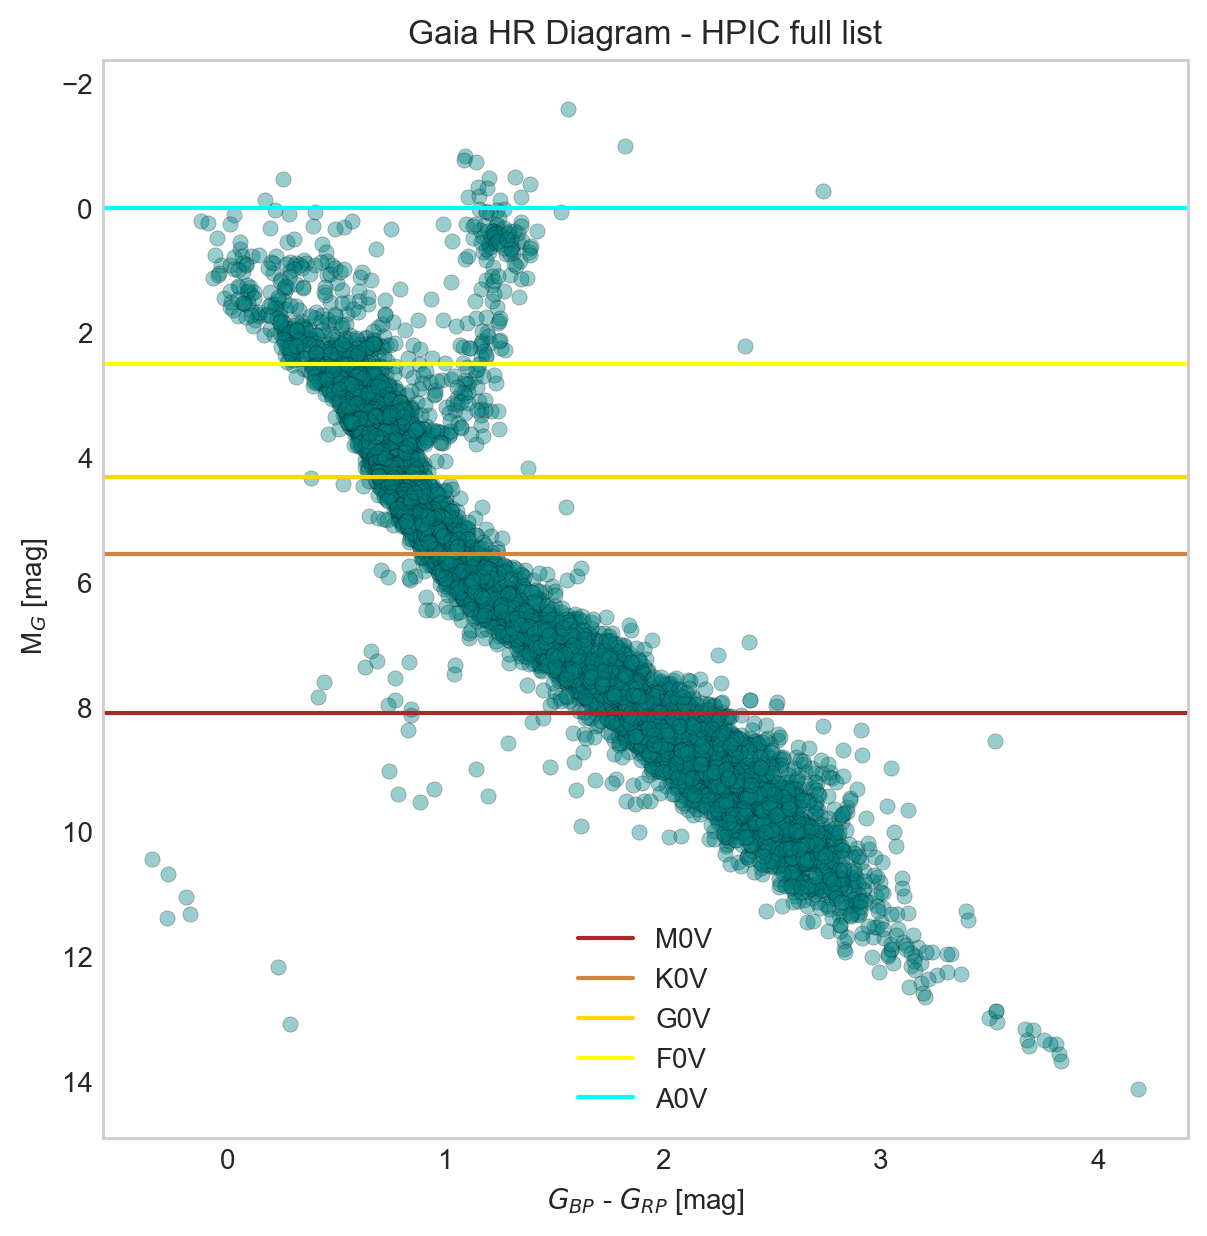

In [9]:
G_mean = df_HWO['sy_gaiamag']  # Convert to float
Plx = df_HWO['sy_plx'] # Convert to float
MG = G_mean - 5*np.log10(1000/Plx) + 5
color = df_HWO['sy_bpmag'] - df_HWO['sy_rpmag']


fig, ax = plt.subplots(figsize=(7,7), dpi=200)
plt.scatter(color,MG, s=30, color='TEAL', alpha=0.4,edgecolors='BLACK',linewidth=0.2)

plt.axhline(8.1,color='brown',label='M0V')
plt.axhline(5.553,color='peru',label='K0V')
plt.axhline(4.32,color='gold',label='G0V')
plt.axhline(2.51,color='yellow',label='F0V')
plt.axhline(0,color='cyan',label='A0V')


plt.title('Gaia HR Diagram - HPIC full list')
plt.ylabel(r' M$_G$ [mag]')
plt.xlabel(r'$G_{BP}$ - $G_{RP}$ [mag]')
plt.grid(False)
plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.savefig('HPIC.FullList.Gaia.HRD.png', rasterize=True)
plt.savefig('HPIC.FullList.Gaia.HRD.pdf', rasterize=True)

/var/folders/24/p64qkln559dgp0ctqn591f600000gn/T/ipykernel_64559/2017705307.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('HPIC.FullList.Hist.png', rasterize=True)
/var/folders/24/p64qkln559dgp0ctqn591f600000gn/T/ipykernel_64559/2017705307.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('HPIC.FullList.Hist.pdf', rasterize=True)


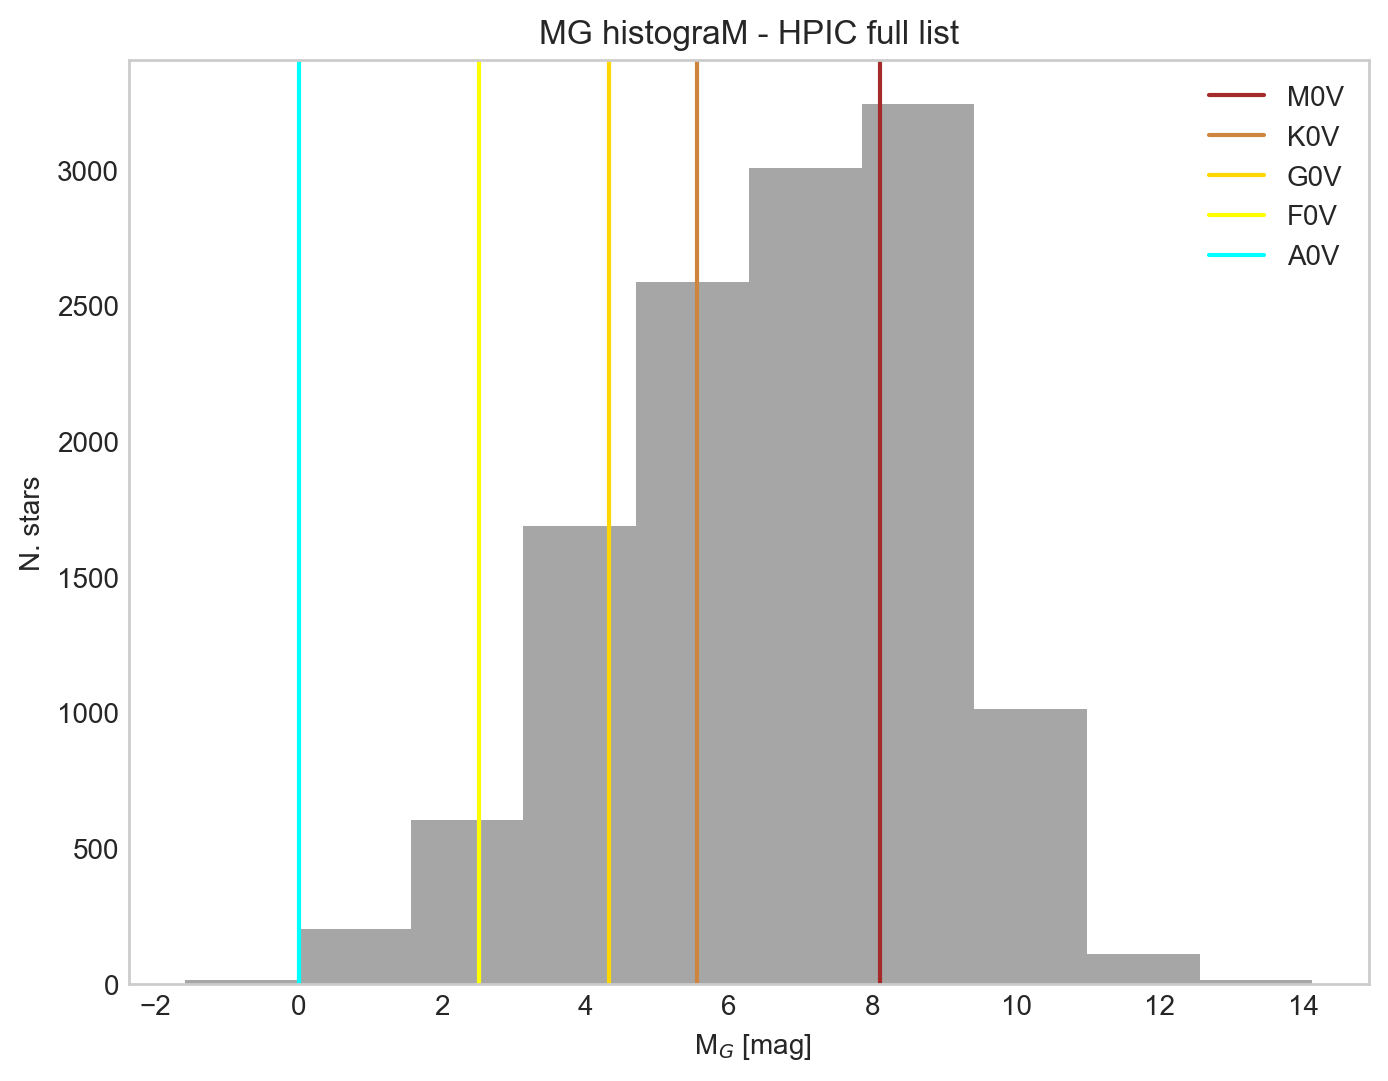

In [14]:
Ffig, ax = plt.subplots(figsize=(8,6), dpi=200)
plt.hist(MG, color='gray', alpha=0.7,linewidth=0.2)

plt.axvline(8.1,color='brown',label='M0V')
plt.axvline(5.553,color='peru',label='K0V')
plt.axvline(4.32,color='gold',label='G0V')
plt.axvline(2.51,color='yellow',label='F0V')
plt.axvline(0,color='cyan',label='A0V')


plt.title('MG histograM - HPIC full list')
plt.ylabel(r'N. stars')
plt.xlabel(r' M$_G$ [mag]')
plt.grid(False)
plt.legend(loc='best')
plt.savefig('HPIC.FullList.Hist.png', rasterize=True)
plt.savefig('HPIC.FullList.Hist.pdf', rasterize=True)

# NOTES

In [11]:
astab_viziercat = Vizier.get_catalogs('V/117A/newcat')
print(astab_viziercat[0].keys())

['Name', 'Comp', 'RAJ2000', 'DEJ2000', 'logTe', '__Fe_H_', 'Dist', 'VMAG', 'Age', 'Vmag', 'b-y', 'RVel', 'e_RVel', 'q', 'vsini', 'Simbad']


In [12]:
table1 = df_HWO #.to_pandas().iloc[idx[sep_constraint]]
table2 = astab_catalog_matches[columns].to_pandas()
merged_df = pd.merge(table1, table2, left_index=True, right_index=True)
merged_df.to_csv('20241113.HWO.Vizier.merge.test2.csv')

In [13]:
astab_viziercat = Vizier.get_catalogs('J/AJ/111/439')
print(astab_viziercat)
#astab_viziercat = Vizier.get_catalogs('J/A+A/545/A32/table45')
astab_catalog = astab_viziercat[0] # Extract the desired catalog
astab_catalog.columns

TableList with 2 tables:
	'0:J/AJ/111/439/table4' with 11 column(s) and 1016 row(s) 
	'1:J/AJ/111/439/notes' with 2 column(s) and 79 row(s) 


<TableColumns names=('HD','m_HD','Vmag','B-V','_tab1_12','Flag','S_CTIO_','S_MW_','logR__HK_','_RA','_DE')>